In [32]:
from pathlib import Path

from corner import corner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from calibration.least_squares import least_squares, ChainStats

In [33]:
RANDOM_SUBSAMPLE = None

In [34]:
BANDS = 'grizy'
BAND_SUPPORT = 'r'
IDX_SUPPORT = BANDS.find(BAND_SUPPORT)

In [35]:
df = pd.read_csv('ps1_des-grizy_probStar99.csv.bz2', engine='pyarrow', )
df = df.sample(n=df.shape[0], replace=False, random_state=0)

if RANDOM_SUBSAMPLE is not None:
    df = df.sample(n=RANDOM_SUBSAMPLE, replace=False, random_state=0)

x = np.stack([df[f"ps1_mag_{band}"] for band in BANDS] + [df[f"des_mag_{BAND_SUPPORT}"]], axis=1)
sigma2 = np.stack([df[f"ps1_magerr_{band}"] for band in BANDS] + [df[f"des_magerr_{BAND_SUPPORT}"]], axis=1)**2

del df


des_ps1 = x[:, -1] - x[:, IDX_SUPPORT]
gr_ps1 = x[:, BANDS.find('g')] - x[:, BANDS.find('r')]
ri_ps1 = x[:, BANDS.find('r')] - x[:, BANDS.find('i')]

print(f'{x.shape[0]} data points')

593236 data points


In [36]:
def plot_residual_hist(residuals, residuals_chi2=None):
    plt.figure()
    residuals_range = np.linspace(-0.04, 0.04, 100)
    residuals_mu, residuals_sigma = np.mean(residuals), np.std(residuals, ddof=3)
    dof = 'χ² / dof = {int(residuals_chi2):,d} / {len(residuals) - 3:,d}\n' if residuals_chi2 is not None else ''
    plt.hist(residuals, bins=residuals_range.shape[0], range=[residuals_range[0], residuals_range[-1]],
             label=f'μ={residuals_mu:.6f}\nσ={residuals_sigma:.6f}\n{dof}Within ± 0.02: {np.mean(np.abs(residuals) < 0.02) * 100:.2f}%')
    plt.legend()
    plt.xlabel(f'PS1 {BAND_SUPPORT} (data - model)')

In [37]:
# import jax
#
# states, ln_probs = least_squares(
#     type='ordinal',
#     x=x,
#     sigma2=sigma2,
#     initial_slopes=[0.020, 1.119, -0.139, -1.0],
#     initial_intercept=0.014,
#     initial_dispersion=0.015,
#     with_dispersion=True,
#     # des_r = ps1_r + alpha (ps1_r - ps1_i) + beta (ps1_g - ps1_r) + intercept + dispersion * N(0, 1)
#     # 3       1              1       2              0       1        4           5
#     # slope0 = beta = internal[1]
#     # slope1 = 1 + alpha - beta = 1 + internal[0] - internal[1]
#     # slope2 = -alpha = -internal[0]
#     # slope3 = -1
#     ls_params_to_internal=lambda ls_param: jax.numpy.r_[-ls_param[2], ls_param[0], ls_param[4], ls_param[5]],
#     internal_params_to_ls=lambda internal: jax.numpy.r_[internal[1], 1 + internal[0] - internal[1], -internal[0], internal[2], internal[3]],
#     # residual_fn=lambda x: jax.numpy.arctan(x),
#     # ask dispersion to be not so large
#     # ln_prior=lambda internal: HalfNormal(scale=0.001).log_prob(internal[-1]),
#     num_samples=10_000,
#     num_burnin=100,
#     nuts_kwargs=dict(step_size=1e-5, parallel_iterations=1),
# )

In [38]:
# plt.figure()
# plt.plot(ln_probs)
#
# corner(
#     data=np.asarray(states),
#     labels=['alpha', 'beta', 'intercept', 'dispersion'],
#     quantiles=[0.05, 0.5, 0.95],
#     show_titles=True,
#     title_fmt='.6f',
#     title_kwargs={"fontsize": 11},
# )
#
# stats = ChainStats.from_states(states)

In [39]:
# alpha, beta, intercept, dispersion = stats.median
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(ri_ps1), min(n_kde, len(ri_ps1)), replace=False)
# sns.kdeplot(x=ri_ps1[idx], y=x[idx, IDX_SUPPORT], levels=20, alpha=0.5)
# plt.scatter(ri_ps1, x[:, 1], color='k', s=0.05, alpha=0.01)
# plt.xlabel(f'PS1 r - i')
# plt.ylabel(f'PS1 {BAND_SUPPORT}')
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(gr_ps1), min(n_kde, len(gr_ps1)), replace=False)
# sns.kdeplot(x=gr_ps1[idx], y=x[idx, IDX_SUPPORT], levels=20, alpha=0.5)
# plt.scatter(gr_ps1, x[:, 1], color='k', s=0.05, alpha=0.01)
# plt.xlabel('PS1 g - r')
# plt.ylabel(f'PS1 {BAND_SUPPORT}')
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(ri_ps1), min(n_kde, len(ri_ps1)), replace=False)
# sns.kdeplot(x=ri_ps1[idx], y=des_ps1[idx], levels=20, alpha=0.5)
# plt.scatter(ri_ps1, des_ps1, color='k', s=0.05, alpha=0.01)
# plt.ylim(-0.1, 0.3)
# plt.xlabel('PS1 r - i')
# plt.ylabel(f'DES {BAND_SUPPORT} - PS1 {BAND_SUPPORT}')
#
# plt.figure()
# n_kde = 10_000
# idx = np.random.choice(len(gr_ps1), min(n_kde, len(ri_ps1)), replace=False)
# sns.kdeplot(x=gr_ps1[idx], y=des_ps1[idx], levels=20, alpha=0.5)
# plt.scatter(gr_ps1, des_ps1, color='k', s=0.05, alpha=0.01)
# # plt.ylim(-0.1, 0.3)
# plt.xlabel('PS1 g - r')
# plt.ylabel(f'DES {BAND_SUPPORT} - PS1 {BAND_SUPPORT}')
#
# plt.figure()
# residuals = des_ps1 - (alpha * ri_ps1 + beta * gr_ps1 + intercept)
# residuals_range = np.linspace(-0.04, 0.04, 100)
# residuals_mu, residuals_sigma = np.mean(residuals), np.std(residuals, ddof=3)
# residuals_chi2 = np.sum(residuals**2 / (sigma2 @ np.square([beta, 1 + alpha + beta, -alpha, -1] + dispersion**2)))
# plt.hist(residuals, bins=residuals_range.shape[0], range=[residuals_range[0], residuals_range[-1]],
#          label=f'μ={residuals_mu:.6f}\nσ={residuals_sigma:.6f}\nχ² / dof = {int(residuals_chi2):,d} / {len(residuals) - 3:,d}\nWithin ± 0.02: {np.mean(np.abs(residuals) < 0.02) * 100:.0f}%')
# plt.legend()
# plt.xlabel('DES r (data - model)')

In [40]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

class Model(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.layers = nn.Sequential(
            nn.Linear(self.in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.layers(x)


class ScaledModel(nn.Module):
    def __init__(self, model: Model, x_scaler: StandardScaler, y_scaler: StandardScaler, idx_support: int):
        super().__init__()

        self.x_scaler = nn.Linear(model.in_features, model.in_features, bias=True)
        self.x_scaler.requires_grad = False
        self.x_scaler.weight = nn.Parameter(torch.diag(torch.tensor(1.0 / x_scaler.scale_, dtype=torch.float32)))
        self.x_scaler.bias = nn.Parameter(torch.tensor(-x_scaler.mean_ / x_scaler.scale_, dtype=torch.float32))

        self.y_scaler = nn.Linear(1, 1, bias=True)
        self.y_scaler.requires_grad = False
        self.y_scaler.weight = nn.Parameter(torch.diag(torch.tensor(y_scaler.scale_, dtype=torch.float32)))
        self.y_scaler.bias = nn.Parameter(torch.tensor(y_scaler.mean_, dtype=torch.float32))

        self.idx_support = idx_support

        self.layers = nn.Sequential(
            self.x_scaler,
            model,
            self.y_scaler,
        )

    def forward(self, x):
        return self.layers(x) + x[:, self.idx_support].unsqueeze(-1)


class RegressionTask(pl.LightningModule):
    def __init__(self, model, learning_rate=3e-4):
        super(RegressionTask, self).__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = torch.mean((predictions.squeeze() - y.squeeze()) ** 2)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = torch.mean((predictions.squeeze() - y.squeeze()) ** 2)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


@dataclass
class TrainedModel:
    idx_support: int
    x_scaler: StandardScaler
    y_scaler: StandardScaler
    task: RegressionTask
    model: Model

    def __call__(self, x):
        x_scaled = torch.tensor(self.x_scaler.transform(x), dtype=torch.float32)
        predictions = self.model(x_scaled)
        predictions_inv_scaled = self.y_scaler.inverse_transform(predictions.detach().numpy()).squeeze()
        return predictions_inv_scaled + x[...,self.idx_support]

    def export(self, path):
        torch.onnx.export(
            model=ScaledModel(self.model, self.x_scaler, self.y_scaler, self.idx_support),
            args=torch.zeros((1, self.x_scaler.n_features_in_), dtype=torch.float32),
            f=path,
            input_names=["input"],
            output_names=["output"],
            dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        )


def train(X, y, X_sigma2, y_sigma2, *, batch_size=1024, n_epoch=300, idx_support):
    y = y - X[:, idx_support]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

    x_scaler = StandardScaler().fit(x_train)
    x_train, x_test = x_scaler.transform(x_train), x_scaler.transform(x_test)

    y_scaler = StandardScaler().fit(y_train[:, None])
    y_train, y_test = y_scaler.transform(y_train[:, None]).squeeze(), y_scaler.transform(y_test[:, None]).squeeze()

    x_train, y_train, x_test, y_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    model = Model(in_features=x_train.shape[1])
    task = RegressionTask(model)

    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1 << 14)

    trainer = pl.Trainer(
        max_epochs=n_epoch,
        accelerator='auto',
        enable_progress_bar=False,
        logger=True,
        callbacks=[
            # LearningRateFinder(),
            EarlyStopping('val_loss', patience=10, mode='min'),
        ]
    )
    trainer.fit(task, train_dataloader, val_dataloader)

    return TrainedModel(
        idx_support=idx_support,
        x_scaler=x_scaler,
        y_scaler=y_scaler,
        task=task,
        model=model,
    )

n_train = int(0.2 * x.shape[0])
sl = slice(0, n_train, 1)

import torch
torch.manual_seed(0)

model_fn = train(
    torch.tensor(x[sl,:-1], dtype=torch.float32),
    torch.tensor(x[sl, -1], dtype=torch.float32),
    torch.tensor(sigma2[sl,:-1], dtype=torch.float32),
    torch.tensor(sigma2[sl, -1], dtype=torch.float32),
    batch_size=1024,
    n_epoch=10000,
    idx_support=IDX_SUPPORT,
)
model_fn.export(f'des_{BAND_SUPPORT}-ps1_{"".join(BANDS)}.onnx')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)
/Users/hombit/.virtualenvs/calibration/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/hombit/.virtualenvs/calibration/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader,

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



(474589,)


<Figure size 640x480 with 0 Axes>

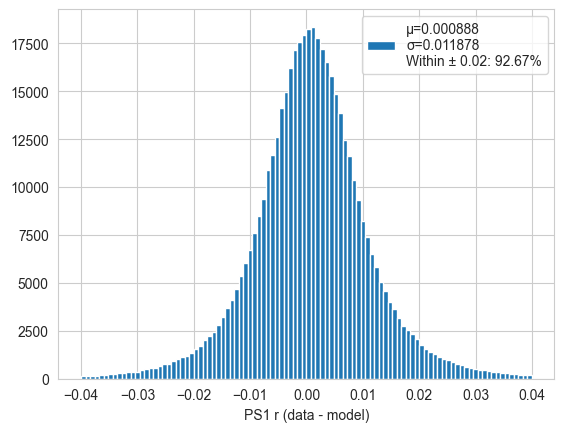

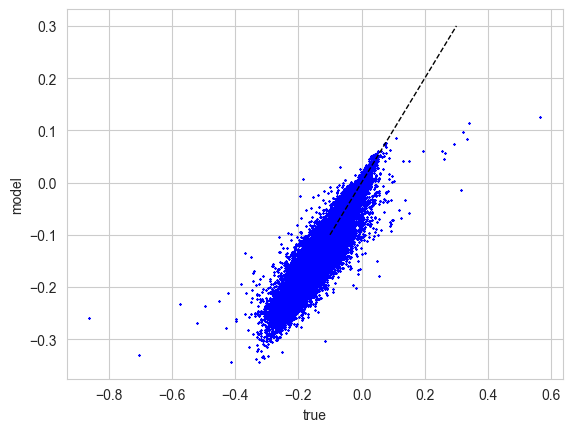

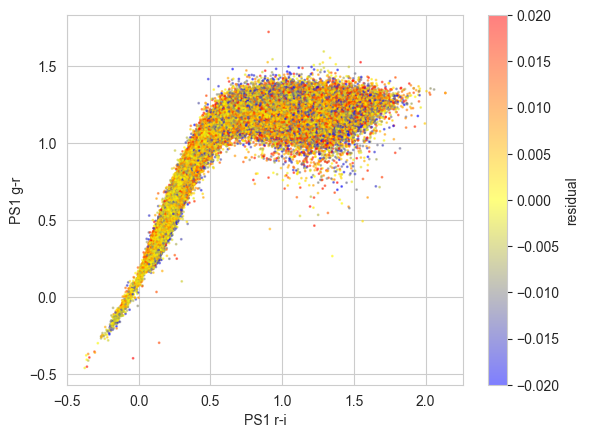

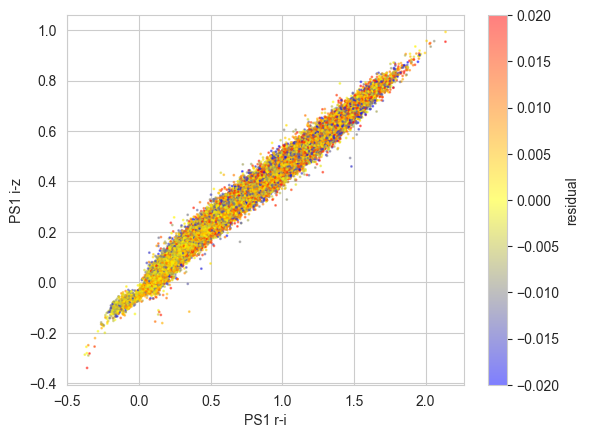

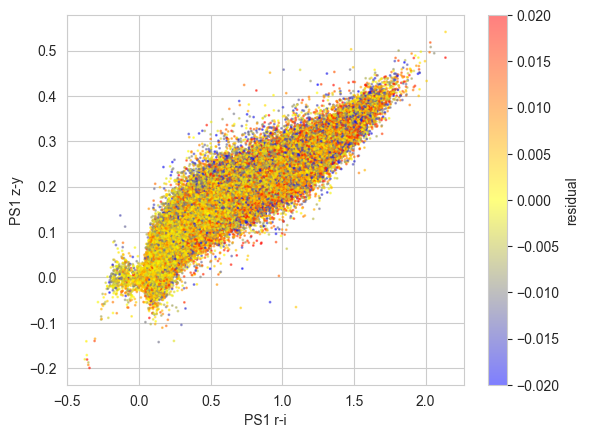

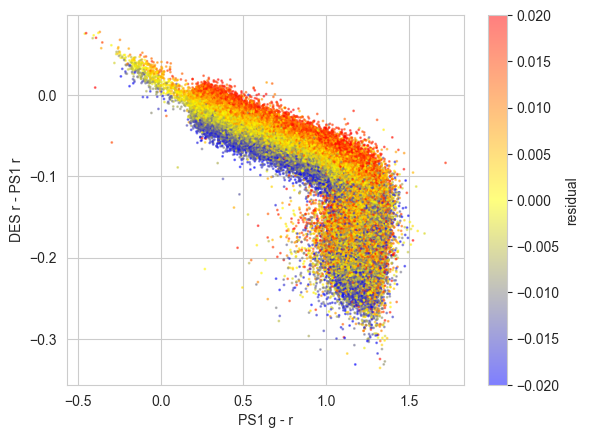

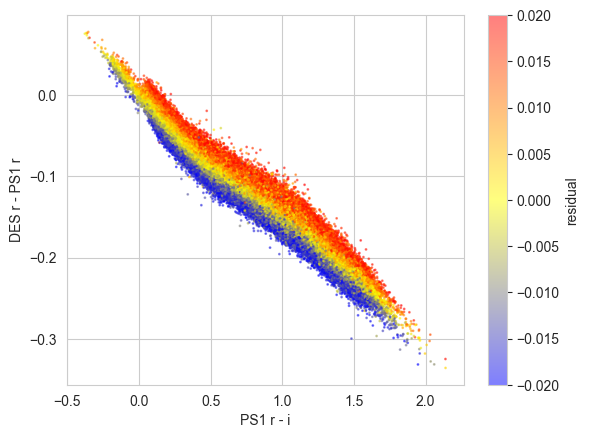

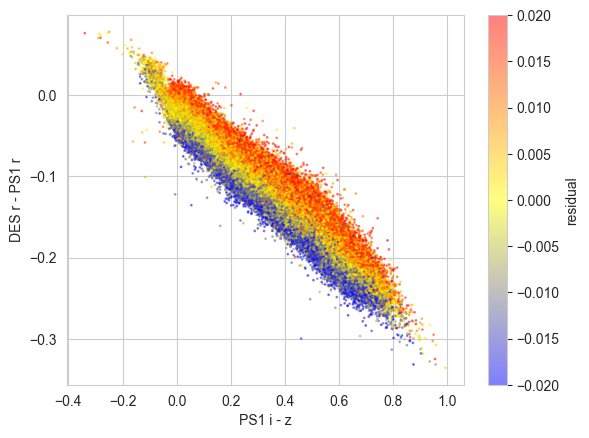

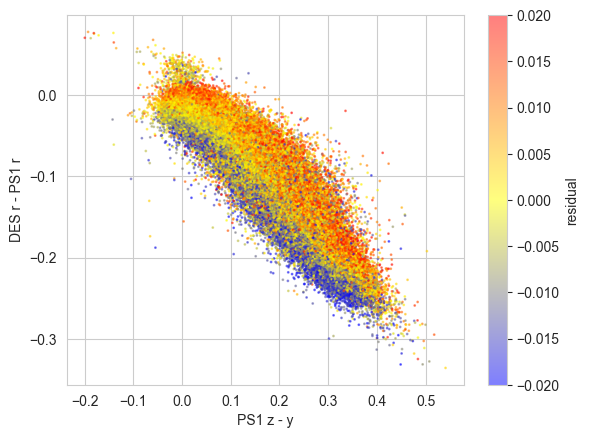

In [41]:
sl = slice(n_train, None, 1)

figpath = Path('figures/phot-transformation/des-ps1')
figpath.mkdir(exist_ok=True, parents=True)

# plt.plot(task.train_losses, label='train')
# plt.plot(task.test_losses, label='test')
# plt.title('learning curve')
# plt.ylim([0.0, 6.0])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()

plt.figure()
pred = model_fn(x[sl, :-1])
print(pred.shape)
plot_residual_hist(x[sl, -1] - pred)
plt.savefig(figpath / 'residual_hist.pdf')

plt.figure()
plt.scatter(x[sl, -1] - x[sl, 1], pred - x[sl, 1],
            s=1, marker='x', color='b')
plt.plot([-0.1, 0.3], [-0.1, 0.3], lw=1, color='k', ls='--')
plt.xlabel('true')
plt.ylabel('model')
plt.savefig(figpath / 'true-vs-model.pdf')

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'custom',
    [(0, 'blue'), (0.5, 'yellow'), (1, 'red')],
    N=256
)

idx = np.abs(x[sl, -1] - pred) <= 0.02
for i_blue_band, (band_blue, band_red) in enumerate(zip(BANDS[:-1], BANDS[1:])):
    if band_blue == 'r' and band_red == 'i':
        continue
    plt.figure()
    plt.scatter(
        x=ri_ps1[sl][idx],
        y=x[:, i_blue_band][sl][idx] - x[:, i_blue_band + 1][sl][idx],
        s=1,
        c=(x[sl, -1] - pred)[idx],
        alpha=0.5,
        vmin=-0.02,
        vmax=0.02,
        cmap=cmap,
    )
    plt.xlabel('PS1 r-i')
    plt.ylabel(f'PS1 {band_blue}-{band_red}')
    plt.colorbar().set_label('residual')
    plt.savefig(figpath / f'{band_blue}-{band_red}_r-i.pdf')

idx = np.abs(x[sl, -1] - pred) <= 0.02
for i_blue_band, (band_blue, band_red) in enumerate(zip(BANDS[:-1], BANDS[1:])):
    plt.figure()
    plt.scatter(
        x=x[:, i_blue_band][sl][idx] - x[:, i_blue_band + 1][sl][idx],
        y=des_ps1[sl][idx],
        s=1,
        c=(x[sl, -1] - pred)[idx],
        alpha=0.5,
        vmin=-0.02,
        vmax=0.02,
        cmap=cmap,
    )
    plt.xlabel(f'PS1 {band_blue} - {band_red}')
    plt.ylabel(f'DES {BAND_SUPPORT} - PS1 {BAND_SUPPORT}')
    plt.colorbar().set_label('residual')
    plt.savefig(figpath / f'DES-PS1_{BAND_SUPPORT}_{band_blue}-{band_red}.pdf')